#### Detect duplicates and 1-channel images in the sample. Those images will be deleted directly from the datasets. We also demonstrate how to perform data augmentation using torchvision.transforms

## Initialize Libraries

In [1]:
import os
import glob

import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image

import urllib.request
from PIL import Image
import matplotlib.pyplot as plt

from google.colab import output
output.enable_custom_widget_manager()
from tqdm import tqdm, trange

# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Remove Corrupted Image (Only run it when needed and with caution)

In [2]:
path_train = '/content/gdrive/MyDrive/Colab Notebooks/Final_data/train'
path_val = '/content/gdrive/MyDrive/Colab Notebooks/Final_data/val'
path_test = '/content/gdrive/MyDrive/Colab Notebooks/Final_data/test'

In [3]:
t_path = path_train
files = sorted(glob.glob(os.path.join(t_path, "*/*.jpg")))
df = pd.DataFrame(
            dict(
                cat=[f.split('/')[-2] for f in files],
                image_path=files
                 ))
df

,cat,image_path
0,Aglaonema_commutatum,/content/gdrive/MyDrive/Colab Notebooks/Final_...
1,Aglaonema_commutatum,/content/gdrive/MyDrive/Colab Notebooks/Final_...
2,Aglaonema_commutatum,/content/gdrive/MyDrive/Colab Notebooks/Final_...
3,Aglaonema_commutatum,/content/gdrive/MyDrive/Colab Notebooks/Final_...
4,Aglaonema_commutatum,/content/gdrive/MyDrive/Colab Notebooks/Final_...
...,...,...
9157,Zamioculcas,/content/gdrive/MyDrive/Colab Notebooks/Final_...
9158,Zamioculcas,/content/gdrive/MyDrive/Colab Notebooks/Final_...
9159,Zamioculcas,/content/gdrive/MyDrive/Colab Notebooks/Final_...
9160,Zamioculcas,/content/gdrive/MyDrive/Colab Notebooks/Final_...


In [4]:
len(df)

9162

In [ ]:
exception_item = []
for i in range(len(df)):
  img_src, cat = df.iloc[i][["image_path", "cat"]]
  print(f'Checking no.{i} image: {img_src}...')
  try:
    with Image.open(img_src) as img:
      img.verify()
  except: 
    # os.remove(img_src)
    print(f'Removed {img_src}')
  if i % 100 == 0:
    print(f'Checked {i} images...')

## Capture Image with only 1 Channel (Only run it when needed)



In [ ]:
list_ch1 = []
for i in range(len(df)):
  img_src, cat = df.iloc[i][["image_path", "cat"]]
  print(f'Checking no.{i} image: {img_src}...')
  with Image.open(img_src) as img:
    if np.array(img).shape[2] == 1:
      list_ch1.append(img_src)
      print(img_src)
  if i % 100 == 0:
    print(f'Checked {i} images...')

In [ ]:
list_ch1

[]

## Replace Label with Serial Numbers

In [5]:
root_path = path_train
folders = os.listdir(root_path)
folders.sort()
label_dict = dict()
for id, folder in enumerate(folders):
  label_dict[folder] = id
label_dict

{'Aglaonema_commutatum': 0,
 'Asplenium_nidus': 1,
 'Calathea_orbifolia': 2,
 'Chamaedorea_elegans': 3,
 'Dracaena_reflexa': 4,
 'Dracaena_trifasciata': 5,
 'Dypsis_lutescens': 6,
 'Epipremnum_aureum': 7,
 'Hoya_carnosa': 8,
 'Maranta_leuconeura': 9,
 'Monstera_deliciosa': 10,
 'Nephrolepis_cordifolia': 11,
 'Pachira_aquatica': 12,
 'Peperomia_argyreia': 13,
 'Peperomia_obtusifolia': 14,
 'Philodendron_gloriosum': 15,
 'Rhapis_excelsa': 16,
 'Schefflera_arboricola': 17,
 'Tradescantia_zebrina': 18,
 'Zamioculcas': 19}

In [6]:
# Generate # of category for applying in neural network
n_class = len(label_dict)
print("n_class", n_class)

n_class 20


## Dataset Pre-Processing

Must be built with __init__, __len__, and __getitem__

Reference: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

\_\_len\_\_: https://pytorch.org/docs/master/data.html#torch.utils.data.Dataset

In [7]:
class GreenFingerDataset(Dataset):

    def __init__(self, data_path, label_dict, oversample=False, transforms=None):
        # retrieve jpg file path from directory: training/validation/testing
        self.files = sorted(glob.glob(os.path.join(data_path, "*/*.jpg")))
        # convert jpg file path to dataframe and attach true label
        self.df = pd.DataFrame(
            dict(
                cat=[f.split('/')[-2] for f in self.files],
                image_path=self.files
            )
        )
        # copy dataframe
        self.df_oversampled = self.df.copy()
        # process oversample function
        if oversample:
            self.oversample()
        # initialize transform procedure
        self.transforms = transforms
        # initialize true label numbering
        self.label_dict = label_dict

    def oversample(self):
        """
        This functions can be called or 
        initialized automatically when the oversample=True
        """
        # Random sampling til the # of sample matches to the # of largest category
        cats = self.df.cat.drop_duplicates().to_numpy()
        cat_sizes = []

        for c in cats:
            n = len(self.df.query(f"cat == '{c}'"))
            cat_sizes.append(n)

        cat_sizes = np.array(cat_sizes)
        dfs = []
        n_majority = np.max(cat_sizes)

        for i, c in enumerate(cats):
            df_cat = self.df.query(f"cat == '{c}'").sample(frac=n_majority/cat_sizes[i], replace=True)
            dfs.append(df_cat)

        self.df_oversampled = pd.concat(dfs, axis=0).reset_index(drop=True)

    def __len__(self):
        return len(self.df_oversampled)

    def __getitem__(self, idx):
        img_src, cat = self.df_oversampled.iloc[idx][["image_path", "cat"]]
        # What's the difference between torchvision's readimage and PIL's Image.open?
        x = Image.open(img_src)
        # x = read_image(img_src)
        if self.transforms:
            x = self.transforms(x)
        x = x.float()
        if len(x.size()) == 2:
            # when it's multi channels, x.size() shows (Channel, Heigh, Weight)
            # when channel is 1, x.size() shows (Heigh, Weight) w/o channel
            x = x.unsqueeze(0) 
            x = torch.cat((x, x, x), axis=0)
        y = self.label_dict[cat]
        y = torch.Tensor([y]).long()
        
        return x, y

## Data Augmentation 

In [8]:
my_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomAffine(degrees=5, scale=(1.2, 1.2), translate=(0.2, 0.1)),
     transforms.RandomResizedCrop(size=1024, scale=(0.2, 1.0), ratio=(1.0, 1.0)),
     transforms.RandomHorizontalFlip(),
     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.05),
    ])

ds_preview = GreenFingerDataset(
    path_train,
    label_dict,
    transforms=my_transforms
)
print("ds", len(ds_preview))

ds 9162


In [9]:
ds_preview[100]

(tensor([[[0.0364, 0.0364, 0.0364,  ..., 0.2548, 0.2508, 0.2449],
          [0.0364, 0.0364, 0.0364,  ..., 0.2587, 0.2547, 0.2488],
          [0.0364, 0.0364, 0.0364,  ..., 0.2613, 0.2576, 0.2536],
          ...,
          [0.1729, 0.1729, 0.1731,  ..., 0.2156, 0.2029, 0.1912],
          [0.1768, 0.1768, 0.1768,  ..., 0.2449, 0.2306, 0.2154],
          [0.1827, 0.1827, 0.1827,  ..., 0.2580, 0.2386, 0.2154]],
 
         [[0.0364, 0.0364, 0.0364,  ..., 0.3816, 0.3777, 0.3718],
          [0.0364, 0.0364, 0.0364,  ..., 0.3855, 0.3816, 0.3757],
          [0.0364, 0.0364, 0.0364,  ..., 0.3882, 0.3844, 0.3805],
          ...,
          [0.2170, 0.2170, 0.2160,  ..., 0.3532, 0.3403, 0.3286],
          [0.2210, 0.2210, 0.2210,  ..., 0.3859, 0.3708, 0.3555],
          [0.2269, 0.2269, 0.2269,  ..., 0.4003, 0.3790, 0.3555]],
 
         [[0.0364, 0.0364, 0.0364,  ..., 0.2347, 0.2308, 0.2249],
          [0.0364, 0.0364, 0.0364,  ..., 0.2386, 0.2347, 0.2288],
          [0.0364, 0.0364, 0.0364,  ...,

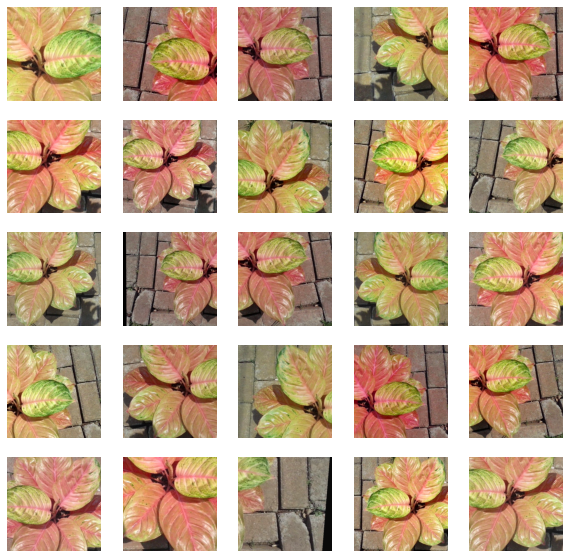

In [16]:
fig = plt.figure(figsize=(10, 10))
plot_row, plot_col = 5, 5
for i in range(plot_row*plot_col):
    img, _ = ds_preview[0]
    plt.subplot(plot_row, plot_col, i+1)
    plt.imshow(torch.permute(img, [1, 2, 0]).numpy())
    plt.axis("off")